# Create a dataset for benchmarking
Combine three datasets:
1. The processed OCR burn probability data
2. The original burn probability data from Riley et al. (to create a "non-burnable" mask)
3. Historical fire perimeters

Note, this script has not been optimized for performance. It requires at least 400GB of memory (I used `m8g.48xlarge`)

In [1]:
import gc
import os 

import geopandas as gpd
import icechunk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio.features
# import seaborn as sns    # plotting
from shapely.geometry import Point
import xarray as xr

from ocr import catalog   # for the riley data

# Read in and pre-process the data

## OCR burn probability

In [2]:
version = '0.13.1'
setup = 'production'

storage = icechunk.s3_storage(
    bucket='carbonplan-ocr',
    prefix=f'output/fire-risk/tensor/{setup}/v{version}/ocr.icechunk',
    from_env=True,
)
repo = icechunk.Repository.open(storage)
session = repo.readonly_session('main')

ds = xr.open_zarr(session.store, consolidated=False, zarr_format=3)

## Riley et al. burn probability

In [3]:
# --- read in 
riley_2011_30m_4326 = catalog.get_dataset('2011-climate-run-30m-4326').to_xarray()[['BP']]
# there are slight mismatches with the coordinates in `ds`
# interpolate riley data to exactly match ds coordinates
riley_interp = riley_2011_30m_4326.interp(
    latitude=ds.latitude,
    longitude=ds.longitude,
    method='nearest'
)
# assign coordinates
ds['riley_BP_2011'] = riley_interp.BP
# create burnable mask
ds['riley_burnable_mask'] = xr.where(ds['riley_BP_2011'] > 0, 1, 0)

## Historical fire perimeters

### + Filter the data
The Inter Agency Fire Perimeter History dataset includes small fires (where reported fire size limits are set by each reporting agency) and prescribed burns. 

We filter out small fires in an effort to omit prescribed and more manageable fires. Based on the National Interagency Fire Center [data](https://www.nifc.gov/fire-information/statistics/prescribed-fire), mean prescribed burns are around 30-50 acres (total fires / total acres). To omit most of these burns, we filter out all fire perimeters with an area less than 75 acres. (Note that there does not appear to be an input marking prescribed burns in the data).

In [4]:
# --- read in historical fire perimeter data (note, it can take a couple mins to load)
fp_path = "s3://carbonplan-ocr/evaluation/"
fp_name = "InterAgencyFirePerimeterHistory_All_Years_View_-104997095188071827.gpkg"
gdf = gpd.read_file(os.path.join(fp_path, fp_name))
# convert CRS
gdf = gdf.to_crs("EPSG:4326")

In [5]:
# --- filter data
min_acres = 75
gdf = gdf[gdf['GIS_ACRES'] > min_acres]

#### Add burn sum and mask and merge with ds

In [6]:
# --- define transform for rasterization
# Assuming lon/lat are 1D arrays
# transform = rasterio.transform.from_bounds(
#     ds.longitude.min(), ds.latitude.min(), ds.longitude.max(), ds.latitude.max(),
#     len(ds.longitude), len(ds.latitude)
# )

transform = rasterio.transform.from_bounds(  # assumes first row in raster corresponds to max latitude...
    ds.longitude.min(), ds.latitude.max(),  # place max lat first to tell transform first row in raster is min lat
    ds.longitude.max(), ds.latitude.min(),  
    len(ds.longitude), len(ds.latitude)
)

# --- compute burn sum
# create (geometry, value) tuples
shapes = [(geom, 1) for geom in gdf.geometry]

# burn all at once
burn_sum = rasterio.features.rasterize(
    [(geom, 1) for geom in gdf.geometry],
    out_shape=(len(ds.latitude), len(ds.longitude)),
    transform=transform,
    all_touched=True,
    dtype=np.uint16,  # allows counts > 255
    merge_alg=rasterio.features.MergeAlg.add,  # sum overlapping polygons
)

# add to dataset
ds['burn_sum'] = (('latitude', 'longitude'), burn_sum)

# get burn mask
ds['burn_mask'] = xr.where(ds['burn_sum'] > 0, 1, 0)

# Save result

In [7]:
# --- delete everything we don't need
del burn_sum, shapes, transform, gdf, riley_interp, riley_2011_30m_4326
gc.collect()

0

In [8]:
# --- rechunk
for name, var in ds.data_vars.items():
    ds[name] = var.chunk({"latitude": 6000, "longitude": 4500})

In [9]:
s3_path = "s3://carbonplan-ocr/evaluation/benchmark-v0131"
savename = "benchmarking-input-dat.zarr"

# write to S3
ds.to_zarr(
    os.path.join(s3_path, savename),
    mode="w",               # overwrite (use "a" to append)
    compute=True,
    storage_options={"anon": False},  # set to True if public bucket
)

/opt/coiled/env/lib/python3.13/site-packages/zarr/api/asynchronous.py:244: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


### Add cell area data and save var 

In [10]:
# add variable for grid cell areas
R = 6371000  # Earth radius (m)
dlat = np.deg2rad(np.abs(ds.latitude.values[1] - ds.latitude.values[0]))
dlon = np.deg2rad(np.abs(ds.longitude.values[1] - ds.longitude.values[0]))

# area for each latitude band (broadcast over lon)
area = (R**2 * dlat * dlon * np.cos(np.deg2rad(ds.latitude.values)))  # 1D over lat
area = xr.DataArray(area, coords=[ds.latitude.values], dims=["latitude"]).broadcast_like(ds)
# convert m2 to km2 
area = area / 1e6

# add var 
ds["cell_area"] = area
ds["cell_area"].attrs["units"] = "km^2"

# write only this variable to the existing store
ds[["cell_area"]].to_zarr(os.path.join(s3_path, savename), mode="a")  # append mode!

Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0xfd039a7e1590>
Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0xfd02f4609310>, 1642.686866878)])']
connector: <aiohttp.connector.TCPConnector object at 0xfd037a8516d0>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0xfd037a853d90>
Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0xfd02f4609010>, 1642.689312478)])']
connector: <aiohttp.connector.TCPConnector object at 0xfd037a851590>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0xfd039a7e1e50>
Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0xfd02f8e97050>, 1642.69094405)])']
connector: <aiohttp.connector.TCPConnector object at 0xfd037a851310>
/opt/coiled/env/lib/python3.13/site-packages/zarr/api/asynchronous.py:244: ZarrUserWarning: Consolidated metadata is currentl

In [11]:
# ------------------------

## Compute quartiles for proportional plot
Restart kernel

Note that we omit burn probabilities of zero for this analysis because east of the 98th meridian BP=0 accounts for more than 20% of all data.

In [1]:
import gc
import os 

import dask.array as da
import geopandas as gpd
import icechunk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio.features
# import seaborn as sns    # plotting
import s3fs
from shapely.geometry import Point
import xarray as xr

from ocr import catalog   # for the riley data


# --- read in dat
s3_path = "s3://carbonplan-ocr/evaluation/benchmark-v090"
savename = "benchmarking-input-dat.zarr"
ds = xr.open_zarr(os.path.join(s3_path, savename))

Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0xef32b179c050>
Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0xef32b1445fd0>, 165.749283725)])']
connector: <aiohttp.connector.TCPConnector object at 0xef32b2fcbc50>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0xef32b179ead0>
Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0xef32b1446450>, 165.750709404)])']
connector: <aiohttp.connector.TCPConnector object at 0xef32b179c2d0>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0xef32b314efd0>
Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0xef32b1446210>, 165.747445481)])']
connector: <aiohttp.connector.TCPConnector object at 0xef32b179ed50>


In [2]:
# --- filter to four slices 
#     (CONUS, west, east, testbox) and later (all data, non-burnable)
slicenames = {
    "testbox": {"minlat": 42.7, "maxlat": 46.3, "minlon": -116.8, "maxlon": -112.8,
                "edges_guess": np.array([9.87079613e-14, 1.49651028e-03, 5.52133492e-03, 1.27165075e-02,
       2.29195178e-02, 1.35098562e-01])},
    "CONUS": {"edges_guess": None },
    "West of -98": {"maxlon": -98,
                "edges_guess": None},
    "East of -98": {"minlon": -98,
                "edges_guess": None},
}

outdict = {}    # to hold outputs
for slc_key, slc_val in slicenames.items():
    if slc_key == "testbox":
        outdict[slc_key] = ds.sel(latitude = slice(slc_val['minlat'], slc_val['maxlat']), 
                                  longitude = slice(slc_val['minlon'], slc_val['maxlon']))
    elif slc_key == "CONUS":
        outdict[slc_key] = ds.copy()

    elif slc_key == "West of -98":
        outdict[slc_key] = ds.where(ds['longitude'] < slc_val['maxlon'], drop=True)

    elif slc_key == "East of -98": 
        outdict[slc_key] = ds.where(ds['longitude'] >= slc_val['minlon'], drop=True)

#### Area-weighted solution 
Start with a guess (or, if no guess, assume equally spaced bins from min to max) and iteratively update the bins based on the difference between the observed bin-areas and the target areas (equal-area). 

In [3]:
def equal_area_bin_edges(bp, area, n_bins=5, rtol=0.02, max_iter=20, edges_guess=None):
    """
    Iteratively find bin edges so each bin has roughly equal total area.

    Parameters
    ----------
    bp : Dask array
        The variable values (e.g., burn probability).
    area : Dask array
        The area of each pixel (same shape as bp).
    n_bins : int
        Number of bins to create.
    rtol : float
        Relative tolerance for equal-area condition. Stops iterating when
        max_area/min_area <= 1 + rtol.
    max_iter : int
        Maximum number of iterations to prevent infinite loops.

    Returns
    -------
    edges : np.ndarray
        Array of bin edges of length n_bins + 1.
    """
    # total area
    total_area = area.sum().compute()
    target_cum_area = np.linspace(0, total_area, n_bins + 1)

    # initial guess: linear in variable values
    if edges_guess is not None:
        edges = edges_guess
    else:
        vmin, vmax = da.nanmin(bp).compute(), da.nanmax(bp).compute()
        edges = np.linspace(vmin, vmax, n_bins + 1)

    for i in range(max_iter):
        print(f"Finding equal-area edges, iteration: {i}")
        # print(f"EDGES: {edges}")
        # compute weighted histogram
        hist_area, _ = da.histogram(bp, bins=edges, weights=area)
        hist_area = hist_area.compute()

        # check if all bins are within the relative tolerance
        if np.isclose(hist_area.max(), hist_area.min(), rtol=rtol):
            print("Found solution")
            break
        else: 
            print(f"MAX: {hist_area.max()} --- MIN: {hist_area.min()}")

        # cumulative area and update edges
        cum_area = np.cumsum(hist_area)
        edges = np.interp(target_cum_area, np.concatenate([[0], cum_area]), edges)
        print(f"IterEdges: {edges}")
    else:
        print(f"Warning: reached max_iter={max_iter} without full convergence")

    return edges


In [ ]:
# --- FAIRLY MEMORY INTENSIVE (~400 GB...) --- 
# --- split the dataset into 5 equal-area burn probability classes and compute expected vs observed burn proportions
#     assume each pixel has the same area
# 
#     Note, this builds on the dataset created in Benchmark 1
# 
save_on = True    # whether to save the data 

for dsname, dsslice in outdict.items():
    # track progress
    print(f"Now solving: {dsname}")

    # pull out dat
    dsslice = outdict[dsname]
    bp = dsslice["burn_probability_2011"]
    bp_nonzero = bp.where(bp > 0)
    burned = dsslice["burn_mask"].where(bp > 0)
    cell_area = dsslice["cell_area"].where(bp > 0)

    # give lat/lon single chunks for dask flattening
    bp_nonzero = bp_nonzero.chunk({"latitude": -1, "longitude": -1})
    cell_area = cell_area.chunk({"latitude": -1, "longitude": -1})

    # flatten lazily 
    bp_flat = bp_nonzero.data.ravel()
    area_flat = cell_area.data.ravel()
    burned_flat = burned.data.ravel()

    # mask invalid entries
    mask = da.isfinite(bp_flat) & da.isfinite(area_flat) & (area_flat > 0)
    bp_flat = da.where(mask, bp_flat, np.nan)
    area_flat = da.where(mask, area_flat, np.nan)
    burned_flat = da.where(mask, burned_flat, np.nan)

    # --- get edges by iteratively solving
    # (this is safer for memory than the brute-force approach)
    edges = equal_area_bin_edges(bp_flat, area_flat, n_bins=5, rtol=0.02, max_iter=30, edges_guess=slicenames[dsname]['edges_guess'])
    print(f"Edges: {edges}")

    # --- expected vs observed proportions (area-weighted)
    def masked_sum(var, cond, area):
        """Compute area-weighted sum over masked region, ignoring NaNs."""
        weighted = var * area * cond
        weighted = da.where(da.isfinite(weighted), weighted, 0)
        return da.nansum(weighted)

    # total weighted sums
    bp_weighted = bp_flat * area_flat
    bp_weighted = da.where(da.isfinite(bp_weighted), bp_weighted, 0)
    total_bp_sum = da.nansum(bp_weighted)

    burned_weighted = (burned_flat == 1) * area_flat
    burned_weighted = da.where(da.isfinite(burned_weighted), burned_weighted, 0)
    total_burned_sum = da.nansum(burned_weighted)

    expected_props = []
    observed_props = []
    expected_sum = []

    # loop through quantile bins
    for i in range(5):
        if i < 4:  # exclude right edge
            cond = (bp_flat >= edges[i]) & (bp_flat < edges[i + 1])
        else:  # include right edge
            cond = (bp_flat >= edges[i]) & (bp_flat <= edges[i + 1])  
        cond = da.where(da.isfinite(cond), cond, False)

        # total area per quantile (nan-safe)
        area_masked = da.where(cond & da.isfinite(area_flat), area_flat, 0)
        area_sum = da.nansum(area_masked)
        expected_sum.append(area_sum)

        # expected = area-weighted mean burn probability within bin
        exp_prop = masked_sum(bp_flat, cond, area_flat) / total_bp_sum
        expected_props.append(exp_prop)

        # observed = area-weighted fraction actually burned
        obs_prop = masked_sum((burned_flat == 1), cond, area_flat) / total_burned_sum
        observed_props.append(obs_prop)

    # bring results into memory
    expected_sum = np.array(da.compute(*expected_sum))
    expected_props = np.array(da.compute(*expected_props))
    observed_props = np.array(da.compute(*observed_props))

    # --- checks
    assert np.isclose(expected_sum.max(), expected_sum.min(), rtol=0.02), \
        "Expected area bins are not approximately equal"
    assert np.isclose(expected_props.sum(), 1.0, atol=1e-2), \
        "Expected proportions do not sum to 1"
    assert np.isclose(observed_props.sum(), 1.0, atol=1e-2), \
        "Observed proportions do not sum to 1"


    # wrap into xarray DataArrays for convenience
    bp_class = np.arange(1, 6)
    expected_sum = xr.DataArray(expected_sum, dims=["bp_class"], coords={"bp_class": bp_class}, name="bp2011_bpclass_sum")
    expected_props = xr.DataArray(expected_props, dims=["bp_class"], coords={"bp_class": bp_class}, name="bp2011_expected_burn_proportion")
    observed_props = xr.DataArray(observed_props, dims=["bp_class"], coords={"bp_class": bp_class}, name="bp2011_observed_burn_proportion")
    right_edges = xr.DataArray(edges[1:], dims=["bp_class"], coords={"bp_class": bp_class}, name="right_bp_edges")
    left_edges = xr.DataArray(edges[:-1], dims=["bp_class"], coords={"bp_class": bp_class}, name="left_bp_edges")


    # combine into a dataset and dataframe
    tmpds_props = xr.merge([expected_props, observed_props, expected_sum, right_edges, left_edges])
    tmpdf_props = tmpds_props.to_dataframe().reset_index()

    
    # save 
    if save_on:
        s3 = s3fs.S3FileSystem()
        path = f"s3://carbonplan-ocr/evaluation/benchmarking-processed/benchmark-v090/{dsname}_burnclass_proportions.parquet"
        with s3.open(path, 'wb') as f:
            tmpdf_props.to_parquet(f)

Now solving: testbox
Finding equal-area edges, iteration: 0
Found solution
Edges: [9.87079613e-14 1.49651028e-03 5.52133492e-03 1.27165075e-02
 2.29195178e-02 1.35098562e-01]
Now solving: CONUS


In [8]:
# --------- NOTICE ME HORTONNNNN
dsname = "CONUS"


# pull out dat
dsslice = outdict[dsname]
bp = dsslice["burn_probability_2011"]
bp_nonzero = bp.where(bp > 0)
burned = dsslice["burn_mask"].where(bp > 0)
cell_area = dsslice["cell_area"].where(bp > 0)

# give lat/lon single chunks for dask flattening
bp_nonzero = bp_nonzero.chunk({"latitude": -1, "longitude": -1})
cell_area = cell_area.chunk({"latitude": -1, "longitude": -1})

# flatten lazily 
bp_flat = bp_nonzero.data.ravel()
area_flat = cell_area.data.ravel()
burned_flat = burned.data.ravel()

# mask invalid entries
mask = da.isfinite(bp_flat) & da.isfinite(area_flat) & (area_flat > 0)
bp_flat = da.where(mask, bp_flat, np.nan)
area_flat = da.where(mask, area_flat, np.nan)
burned_flat = da.where(mask, burned_flat, np.nan)


bp = bp_flat
area = area_flat



# edges_guess = np.array(


print("CHECK 1 -- start fxn")

total_area = area.sum().compute()
target_cum_area = np.linspace(0, total_area, n_bins + 1)

# initial guess: linear in variable values
if edges_guess is not None:
    edges = edges_guess
else:
    vmin, vmax = da.nanmin(bp).compute(), da.nanmax(bp).compute()
    edges = np.linspace(vmin, vmax, n_bins + 1)

print("CHECK 2 -- Areas & Edges defined --> Enter For loop")

for i in range(max_iter):
    print(f"Finding equal-area edges, iteration: {i}")
    # print(f"EDGES: {edges}")
    # compute weighted histogram
    hist_area, _ = da.histogram(bp, bins=edges, weights=area)
    hist_area = hist_area.compute()

    print("CHECK 3 -- hist computed")
    
    # check if all bins are within the relative tolerance
    if np.isclose(hist_area.max(), hist_area.min(), rtol=rtol):
        print("Found solution")
        break
    else: 
        print(f"MAX: {hist_area.max()} --- MIN: {hist_area.min()}")

    # cumulative area and update edges
    cum_area = np.cumsum(hist_area)
    edges = np.interp(target_cum_area, np.concatenate([[0], cum_area]), edges)
    print(f"IterEdges: {edges}")
else:
    print(f"Warning: reached max_iter={max_iter} without full convergence")


CHECK 1 -- start fxn


KeyboardInterrupt: 

In [6]:
# ----------------------------------------------
# 
# TRYING A (MAYBE) LESS MEMORY INTENSIVE VERSION
# 

dsname = "CONUS"

dsslice = outdict[dsname]




# [ FUNCTION TO GET EDGES ] ====================
def weighted_quantile_edges(bp, area, n_bins=5):
    """Approximate equal-area bin edges via weighted quantiles."""
    # Normalize weights
    weights = da.where(da.isfinite(bp) & da.isfinite(area) & (area > 0), area, 0)
    total = weights.sum()
    # approximate quantiles
    qs = da.linspace(0, 1, n_bins + 1)
    edges = da.percentile(bp, qs * 100, interpolation="linear")
    return edges.compute()


# [ COARSEN INPUTS ] =============================
print("CHECK 0: Coarsen inputs")

def majority_func_safe(x, **kwargs):
    # Convert Dask array / chunk to concrete NumPy array
    x = np.asarray(x)   # safe even if x is unknown chunk size
    x = x.ravel()
    x = x[~np.isnan(x)]
    if x.size == 0:     # use x.size instead of len(x)
        return np.nan
    return 1 if np.sum(x) >= x.size / 2 else 0


bp = dsslice["burn_probability_2011"]
burned = dsslice["burn_mask"]
area = dsslice["cell_area"]

# coarsen
bp = bp.coarsen(latitude=10, longitude=10, boundary='trim').mean()
area = area.coarsen(latitude=10, longitude=10, boundary='trim').sum()
burned = burned.coarsen(latitude=10, longitude=10, boundary='trim').reduce(majority_func_safe)



# [ THE REST ] ===================================

print("CHECK 1: Creating mask + stacked")

# Mask
mask = (bp > 0) & da.isfinite(area)
bp, burned, area = bp.where(mask), burned.where(mask), area.where(mask)

# Stack spatial dims efficiently
stacked = xr.Dataset({'bp': bp, 'burned': burned, 'area': area}).stack(pix=("latitude", "longitude"))


print("CHECK 2: Compute edges (weighted_quantile_edges fxn)")

# Compute weighted quantile edges
edges = weighted_quantile_edges(stacked.bp.data, stacked.area.data, n_bins=5)

# Expected vs observed in one compute pass
expected_sum = []
expected_props = []
observed_props = []

print("CHECK 3: Get total BPs and burned")

total_bp_sum = da.nansum(stacked.bp * stacked.area)
total_burned_sum = da.nansum((stacked.burned == 1) * stacked.area)

print("CHECK 4: Start for loop")

for i in range(5):
    # ==================================
    print(f"CHECK ME: iteration {i}")
    # ==================================
    cond = (stacked.bp >= edges[i]) & (stacked.bp < edges[i + 1])
    area_mask = stacked.area.where(cond)
    expected_sum.append(da.nansum(area_mask))
    expected_props.append(da.nansum(stacked.bp.where(cond) * stacked.area) / total_bp_sum)
    observed_props.append(da.nansum((stacked.burned == 1).where(cond) * stacked.area) / total_burned_sum)

expected_sum, expected_props, observed_props = da.compute(expected_sum, expected_props, observed_props)


CHECK 0: Coarsen inputs


ValueError: dimensions ('latitude', 'longitude') must have the same length as the number of data dimensions, ndim=0

In [ ]:
# --- FAIRLY MEMORY INTENSIVE (~400 GB...) --- 
# 
# --- [ REPEAT FOR NON-BURNABLE ] ------------
# 
# --- split the dataset into 5 equal-area burn probability classes and compute expected vs observed burn proportions
#     assume each pixel has the same area
# 
#     Note, this builds on the dataset created in Benchmark 1
# 
save_on = True    # whether to save the data 

for dsname, dsslice in outdict.items():
    # track progress
    print(f"Now solving: {dsname}")

    # pull out dat
    dsslice = outdict[dsname]
    bp = dsslice['burn_probability_2011'].where(dsslice['riley_burnable_mask'] == 0)
    bp_nonzero = bp.where(bp > 0)
    burned = dsslice['burn_mask'].where(dsslice['riley_burnable_mask'] == 0)

    # pull out dat
    dsslice = outdict[dsname]
    bp = dsslice["burn_probability_2011"].where(dsslice['riley_burnable_mask'] == 0)
    bp_nonzero = bp.where(bp > 0)
    burned = dsslice["burn_mask"].where((bp > 0) & (dsslice['riley_burnable_mask'] == 0))
    cell_area = dsslice["cell_area"].where((bp > 0) & (dsslice['riley_burnable_mask'] == 0))

    # give lat/lon single chunks for dask flattening
    bp_nonzero = bp_nonzero.chunk({"latitude": -1, "longitude": -1})
    cell_area = cell_area.chunk({"latitude": -1, "longitude": -1})

    # flatten lazily 
    bp_flat = bp_nonzero.data.ravel()
    area_flat = cell_area.data.ravel()
    burned_flat = burned.data.ravel()

    # mask invalid entries
    mask = da.isfinite(bp_flat) & da.isfinite(area_flat) & (area_flat > 0)
    bp_flat = da.where(mask, bp_flat, np.nan)
    area_flat = da.where(mask, area_flat, np.nan)
    burned_flat = da.where(mask, burned_flat, np.nan)

    # --- get edges by iteratively solving
    # (this is safer for memory than the brute-force approach)
    edges = equal_area_bin_edges(bp_flat, area_flat, n_bins=5, rtol=0.02, max_iter=30, edges_guess=slicenames[dsname]['edges_guess'])


    # --- expected vs observed proportions (area-weighted)
    def masked_sum(var, cond, area):
        """Compute area-weighted sum over masked region, ignoring NaNs."""
        weighted = var * area * cond
        weighted = da.where(da.isfinite(weighted), weighted, 0)
        return da.nansum(weighted)

    # total weighted sums
    bp_weighted = bp_flat * area_flat
    bp_weighted = da.where(da.isfinite(bp_weighted), bp_weighted, 0)
    total_bp_sum = da.nansum(bp_weighted)

    burned_weighted = (burned_flat == 1) * area_flat
    burned_weighted = da.where(da.isfinite(burned_weighted), burned_weighted, 0)
    total_burned_sum = da.nansum(burned_weighted)

    expected_props = []
    observed_props = []
    expected_sum = []

    # loop through quantile bins
    for i in range(5):
        if i < 4:  # exclude right edge
            cond = (bp_flat >= edges[i]) & (bp_flat < edges[i + 1])
        else:  # include right edge
            cond = (bp_flat >= edges[i]) & (bp_flat <= edges[i + 1])  
        cond = da.where(da.isfinite(cond), cond, False)

        # total area per quantile (nan-safe)
        area_masked = da.where(cond & da.isfinite(area_flat), area_flat, 0)
        area_sum = da.nansum(area_masked)
        expected_sum.append(area_sum)

        # expected = area-weighted mean burn probability within bin
        exp_prop = masked_sum(bp_flat, cond, area_flat) / total_bp_sum
        expected_props.append(exp_prop)

        # observed = area-weighted fraction actually burned
        obs_prop = masked_sum((burned_flat == 1), cond, area_flat) / total_burned_sum
        observed_props.append(obs_prop)

    # bring results into memory
    expected_sum = np.array(da.compute(*expected_sum))
    expected_props = np.array(da.compute(*expected_props))
    observed_props = np.array(da.compute(*observed_props))

    # --- checks
    assert np.isclose(expected_sum.max(), expected_sum.min(), rtol=0.02), \
        "Expected area bins are not approximately equal"
    assert np.isclose(expected_props.sum(), 1.0, atol=1e-2), \
        "Expected proportions do not sum to 1"
    assert np.isclose(observed_props.sum(), 1.0, atol=1e-2), \
        "Observed proportions do not sum to 1"


    # wrap into xarray DataArrays for convenience
    bp_class = np.arange(1, 6)
    expected_sum = xr.DataArray(expected_sum, dims=["bp_class"], coords={"bp_class": bp_class}, name="bp2011_bpclass_sum")
    expected_props = xr.DataArray(expected_props, dims=["bp_class"], coords={"bp_class": bp_class}, name="bp2011_expected_burn_proportion")
    observed_props = xr.DataArray(observed_props, dims=["bp_class"], coords={"bp_class": bp_class}, name="bp2011_observed_burn_proportion")
    right_edges = xr.DataArray(edges[1:], dims=["bp_class"], coords={"bp_class": bp_class}, name="right_bp_edges")
    left_edges = xr.DataArray(edges[:-1], dims=["bp_class"], coords={"bp_class": bp_class}, name="left_bp_edges")


    # combine into a dataset and dataframe
    tmpds_props = xr.merge([expected_props, observed_props, expected_sum, right_edges, left_edges])
    tmpdf_props = tmpds_props.to_dataframe().reset_index()

    
    # save 
    if save_on:
        s3 = s3fs.S3FileSystem()
        path = f"s3://carbonplan-ocr/evaluation/benchmarking-processed/{dsname}_burnclass_proportions.parquet"
        with s3.open(path, 'wb') as f:
            tmpdf_props.to_parquet(f)

## WIP: Compute LSS ...
Note: The random reference model is expensive and takes a long time to generate for CONUS (I haven't been patient enough to generate it yet). Consider just using the uniform model. 

### Compute the logarithmic score (LS) and logarithmic skill score (LSS)
Following Maron et al., 2025, the logarithmic score is defined by:

$\text{LS} = \frac{1}{N}\sum^{N}_{i-1} - \text{ln}\left(1-\left|p_i-o_i\right|\right)$

where $p_i$ is the burn probability of pixel $i$ and $o_i$ is the burn mask binary outcome (1 for burned, 0 for not burned).

We compute the $\text{LS}$ for the burn probability model as well as the two reference cases (random and uniform). THen we can compute the logarithmic skill score of the model relative to the reference cases by:

$\text{LSS} = 1 - \frac{\text{LS}}{\text{LS}_\text{ref}}$

where $\text{LS}_\text{ref}$ refers to either the random or uniform case logarithmic score.

In [3]:
import dask.array as da 


dsslice = outdict['CONUS']


bp = dsslice['burn_probability_2011']
burn_mask = dsslice['burn_mask']

# --- reference models
# print("working on RANDOM model ... ")
# flat = bp.data.compute().flatten()           # compute into RAM
# np.random.shuffle(flat)                       # in-place shuffle
# shuffled = flat.reshape(bp.shape)
# bp_ref_random = xr.DataArray(shuffled, dims=bp.dims, coords=bp.coords, name="burn_probability_2011_REF_random")
# dsslice['burn_probability_2011_REF_random'] = bp_ref_random

# uniform mean
print("working on UNIFORM model ... ")
mean_bp = bp.mean()  # lazy if Dask
bp_ref_uniform = xr.full_like(bp, fill_value=mean_bp)
bp_ref_uniform.name = "burn_probability_2011_REF_uniform"
dsslice['burn_probability_2011_REF_uniform'] = bp_ref_uniform

working on UNIFORM model ... 


In [4]:
dsslice['burn_probability_2011_REF_uniform']

<xarray.DataArray 'burn_probability_2011_REF_uniform' (latitude: 97579,
                                                       longitude: 208881)> Size: 82GB
dask.array<full_like, shape=(97579, 208881), dtype=float32, chunksize=(6000, 4500), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 781kB 52.48 52.48 52.48 ... 22.43 22.43 22.43
  * longitude  (longitude) float64 2MB -128.4 -128.4 -128.4 ... -64.05 -64.05

In [ ]:
# ... maybe this approach is faster...?

import dask.array as da 


dsslice = outdict['CONUS']

bp = dsslice['burn_probability_2011']
burn_mask = dsslice['burn_mask']


bp_da = bp.data if isinstance(bp.data, da.Array) else da.from_array(bp.data, chunks=bp.chunks)
shape = bp_da.shape
# flatten lazily
flat = bp_da.reshape(-1)
# generate a permutation of indices lazily
idx = da.arange(flat.size)
idx = da.random.permutation(idx)  # note: this works lazily without chunks argument
# index into the flattened array lazily
shuffled_flat = flat[idx]
# reshape back to 2D
shuffled_bp_da = shuffled_flat.reshape(shape)
# wrap back in DataArray
bp_ref_random = xr.DataArray(shuffled_bp_da, dims=bp.dims, coords=bp.coords,
                             name="burn_probability_2011_REF_random")

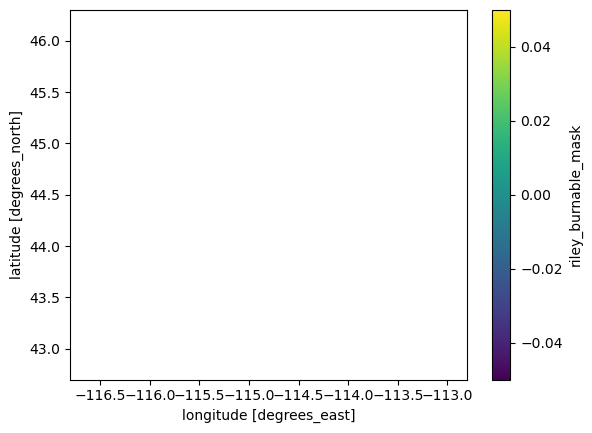

In [10]:
# dsslice['burn_probability_2011'].where('riley_burnable_mask' == 0)
dsslice['riley_burnable_mask'].where('riley_burnable_mask' == 0).plot()

In [13]:
observed_props.sum()

<xarray.DataArray 'burn_mask' ()> Size: 8B
array(0.95375784)